In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas
import gensim

import matplotlib.pyplot as plt
import matplotlib

from sklearn.cross_validation import train_test_split
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing

import numpy as np

from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout

matplotlib.style.use('ggplot')

Using Theano backend.


## 1. Read and train w2v model

In [3]:
blosum_file = "../data/blosum.csv"

In [4]:
blosum = pandas.read_csv(blosum_file, sep = ',')

d = dict()
c = 0
for i in range(20):
    d[blosum['x'][i]] = blosum[[i + 1]]
    
def seq2vec(seq):
    answer = []
    for i in list(seq):
        answer.append(d[i].as_matrix().flatten())
    return np.array(answer, dtype=float).flatten()

## 2. Read and prepare data

In [5]:
data_file = "../data/bdata.log.txt"

data = pandas.read_csv(data_file, sep = ',')

In [6]:
data.head()

,species,mhc,peptide_length,cv,sequence,inequality,meas
0,cow,BoLA-HD6,9,TBD,ALFYKDGKL,=,1.000000
1,cow,BoLA-HD6,9,TBD,ALYEKKLAL,=,1.000000
2,cow,BoLA-HD6,9,TBD,AMKDRFQPL,=,0.860543
3,cow,BoLA-HD6,9,TBD,AQRELFFTL,=,1.000000
4,cow,BoLA-HD6,9,TBD,FMKVKFEAL,=,0.957914


In [12]:
selected_mhc = 'human'

indexes = data['mhc'][data['species'] == selected_mhc].index
indexes = data.iloc[indexes]['mhc'][data['peptide_length'] == 9].index

selected_X = list(data['sequence'][indexes].apply(seq2vec))
selected_X = pandas.DataFrame(selected_X)

selected_y = data['meas'][indexes]

#selected_X = pandas.concat([selected_X, selected_Xmhc], axis=1)

selected_X.to_csv('blosum_feats.csv')

selected_X.shape

(116955, 180)

In [13]:

selected_Xmhc = data['mhc'][indexes]
selected_Xmhc = pandas.get_dummies(selected_Xmhc)

selected_Xmhc.to_csv('blosum_one.csv')



In [14]:
selected_y.to_csv('lol_pred.csv')

## 3. Learn linear regression

In [7]:
#normalize output
# m = selected_y.mean()
# d = selected_y.max() - selected_y.min()
# selected_y = (selected_y - m) / d

# train/test split
np.random.seed(42)
random_number = 122222
X_train, X_test, y_train, y_test = train_test_split(selected_X, selected_y,
                                                    test_size = 0.33, random_state = random_number)

In [8]:
def ridge_regression(X, y, alpha):
    #Fit the model
    ridgereg = Ridge(alpha=alpha,normalize=True)
    ridgereg.fit(X, y)
    y_pred = ridgereg.predict(X).clip(min = 0)
    
    #Return the result in pre-defined format
    rss = sum((y_pred - y)**2)
    return rss, ridgereg.intercept_, ridgereg

In [9]:
alpha_ridge = [0.001, 0.02, 0.03, 0.04, 0.05,0.06, 0.07, 0.08, 0.09, 0.1]

rss = [0] * 10
intercept = [0] * 10
predictors = [0] * 10

for i in range(10):
    rss[i], intercept[i], predictors[i] = ridge_regression(X_train, y_train, alpha_ridge[i])

In [10]:
# predict test data

test_rss = [0] * 10
for i in range(10):
    m_pred = predictors[i]
    test_pred = m_pred.predict(X_test).clip(min = 0)
    test_rss[i] = sum((test_pred - y_test)**2)
    
    print '-' * 10
    print "alpha = ", alpha_ridge[i]
    print "train rss = ", rss[i]
    print "test rss = ", test_rss[i]


m_pred = predictors[0]
t_pred = m_pred.predict(X_test)

----------
alpha =  0.001
train rss =  84.7818331932
test rss =  45.0349758663
----------
alpha =  0.02
train rss =  87.171689542
test rss =  46.0701458251
----------
alpha =  0.03
train rss =  88.2459643503
test rss =  46.5240559244
----------
alpha =  0.04
train rss =  89.2623476941
test rss =  46.9548678686
----------
alpha =  0.05
train rss =  90.2218327302
test rss =  47.3669296516
----------
alpha =  0.06
train rss =  91.1259518538
test rss =  47.7630030115
----------
alpha =  0.07
train rss =  91.9817581449
test rss =  48.144096878
----------
alpha =  0.08
train rss =  92.7951145862
test rss =  48.5098308243
----------
alpha =  0.09
train rss =  93.5702701274
test rss =  48.8588482197
----------
alpha =  0.1
train rss =  94.3123035154
test rss =  49.1930588435


In [11]:
t_pred = pandas.DataFrame(t_pred)
t_pred[t_pred < 0] = 0
t_pred.describe()

,0
count,1727.000000
mean,0.253346
std,0.190128
min,0.000000
25%,0.089023
50%,0.227153
75%,0.407830
max,0.757049


In [12]:
t_pred = pandas.DataFrame(t_pred)

and so on...

In [13]:
y_test = pandas.DataFrame(y_test)

In [14]:
t_pred['1'] = np.array(y_test)

In [15]:
t_pred.corr()

,0,1
0,1.000000,0.775464
1,0.775464,1.000000


## 4. NN time

In [16]:
X_train = X_train.as_matrix()
X_test = X_test.as_matrix()

y_train = y_train.as_matrix().flatten()
y_test = y_test.as_matrix().flatten()

In [17]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1]))
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.15))
model.add(Dense(1))

model.compile(loss='mse', optimizer='rmsprop')

In [18]:
model.fit(X_train, y_train, batch_size=32, nb_epoch=500, verbose=2, validation_split=0.15)

Train on 2978 samples, validate on 526 samples
Epoch 1/500
0s - loss: 0.6552 - val_loss: 0.1187
Epoch 2/500
0s - loss: 0.1081 - val_loss: 0.0572
Epoch 3/500
0s - loss: 0.0562 - val_loss: 0.0525
Epoch 4/500
0s - loss: 0.0411 - val_loss: 0.0334
Epoch 5/500
0s - loss: 0.0343 - val_loss: 0.0341
Epoch 6/500
0s - loss: 0.0295 - val_loss: 0.0343
Epoch 7/500
0s - loss: 0.0266 - val_loss: 0.0386
Epoch 8/500
0s - loss: 0.0242 - val_loss: 0.0266
Epoch 9/500
0s - loss: 0.0213 - val_loss: 0.0320
Epoch 10/500
0s - loss: 0.0209 - val_loss: 0.0256
Epoch 11/500
0s - loss: 0.0182 - val_loss: 0.0332
Epoch 12/500
0s - loss: 0.0171 - val_loss: 0.0331
Epoch 13/500
0s - loss: 0.0154 - val_loss: 0.0345
Epoch 14/500
0s - loss: 0.0153 - val_loss: 0.0274
Epoch 15/500
0s - loss: 0.0143 - val_loss: 0.0259
Epoch 16/500
0s - loss: 0.0135 - val_loss: 0.0253
Epoch 17/500
0s - loss: 0.0136 - val_loss: 0.0241
Epoch 18/500
0s - loss: 0.0129 - val_loss: 0.0268
Epoch 19/500
0s - loss: 0.0119 - val_loss: 0.0258
Epoch 20/500

In [21]:
preds = model.predict(X_test, verbose=0).flatten()

In [22]:
sum((preds - y_test)**2)

44.656929272005158

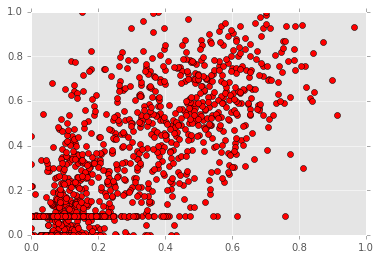

In [24]:
preds2 = preds.clip(min = 0)
preds2 = preds2.clip(max = 1)
sum((preds2 - y_test)**2)

plt.plot(preds2, y_test, 'ro')